(pathfinder)=

# Pathfinder Variational Inference

:::{post} Feb 5, 2023 
:tags: variational inference, jax 
:category: advanced, how-to
:author: Thomas Wiecki
:::

Pathfinder {cite:p}`zhang2021pathfinder` is a variational inference algorithm that produces samples from the posterior of a Bayesian model. It compares favorably to the widely used ADVI algorithm. On large problems, it should scale better than most MCMC algorithms, including dynamic HMC (i.e. NUTS), at the cost of a more biased estimate of the posterior. For details on the algorithm, see the [arxiv preprint](https://arxiv.org/abs/2108.03782).

This algorithm is [implemented](https://github.com/blackjax-devs/blackjax/pull/194) in [BlackJAX](https://github.com/blackjax-devs/blackjax), a library of inference algorithms for [JAX](https://github.com/google/jax). Through PyMC's JAX-backend (through [pytensor](https://github.com/pytensor-devs/pytensor)) we can run BlackJAX's pathfinder on any PyMC model with some simple wrapper code.

This wrapper code is implemented in [pymc-experimental](https://github.com/pymc-devs/pymc-experimental/). This tutorial shows how to run Pathfinder on a simple PyMC model.

You first need to install `pymc-experimental`:

`pip install git+https://github.com/pymc-devs/pymc-experimental`

Instructions for installing other packages:  
- [jax](https://github.com/google/jax#installation)
- [blackjax](https://pypi.org/project/blackjax/)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_experimental as pmx
import seaborn as sns

from sklearn.datasets import make_biclusters

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


We will demonstrate Pathfinder on a simple logistic regression model. Follwing the example in [The Sampling Book](https://blackjax-devs.github.io/sampling-book/algorithms/pathfinder.html#the-data), we will use scikit-learn's `make_biclusters` to generate a synthetic dataset.

In [2]:
N = 50
X, rows, cols = make_biclusters((N, 2), 2, noise=0.6, random_state=42, minval=-3, maxval=3)
y = rows[0].astype(np.float32)

df = pd.DataFrame(X, columns=["Variable1", "Variable2"])
df["y"] = y

<Axes: xlabel='Variable1', ylabel='Variable2'>

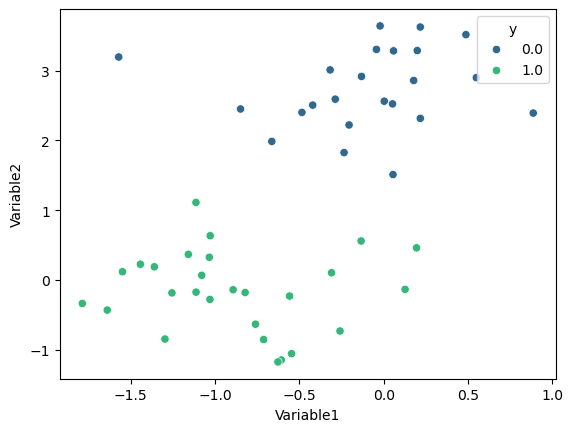

In [3]:
sns.scatterplot(data=df, x="Variable1", y="Variable2", hue="y", palette="viridis")

A logistic regression model can be used to infer the cluster membership of each data point:

$$
y \sim \text{Bernoulli}(p)
$$

where the probability of being in a cluster is given by:

$$
p = \text{sigmoid}(X w)
$$

We will use a normal distribution as our prior for the weights:

$$
w \sim \text{Normal}(0, \sigma)
$$

In [4]:
with pm.Model() as model:
    sigma = pm.HalfNormal("sigma", sigma=1)
    w = pm.Normal("w", mu=0, sigma=sigma, shape=2)
    y_hat = X @ w
    pm.Bernoulli("y", p=pm.math.sigmoid(y_hat), observed=y)

Next, we call `pmx.fit()` and pass "pathfinder" as the variational inference method.

In [5]:
with model:
    idata = pmx.fit(method="pathfinder", num_samples=1000)

Running pathfinder...
Transforming variables...


Just like `pymc.sample()`, this returns an idata with samples from the posterior. Note that because these samples do not come from an MCMC chain, convergence can not be assessed in the regular way.

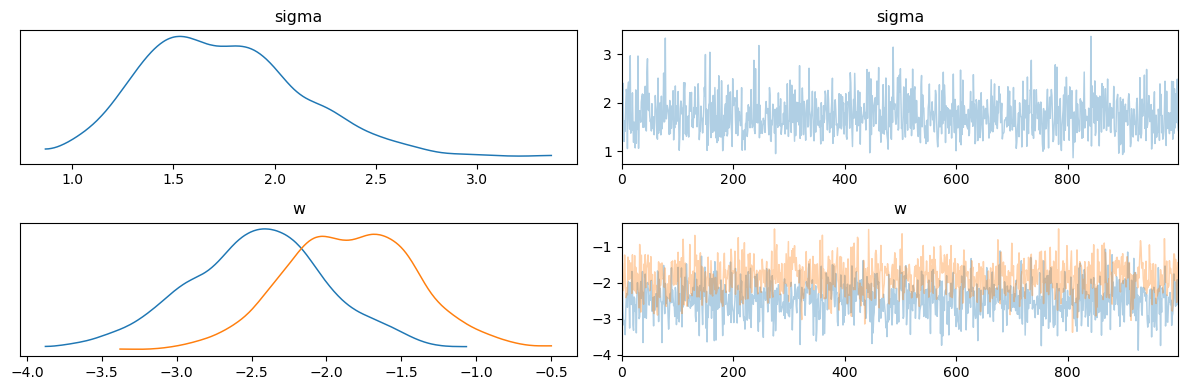

In [6]:
az.plot_trace(idata)
plt.tight_layout();

In [7]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [y]


Output()

The model has done a reasonable job of estimating the group membership probabilities.

<Axes: xlabel='Variable1', ylabel='Variable2'>

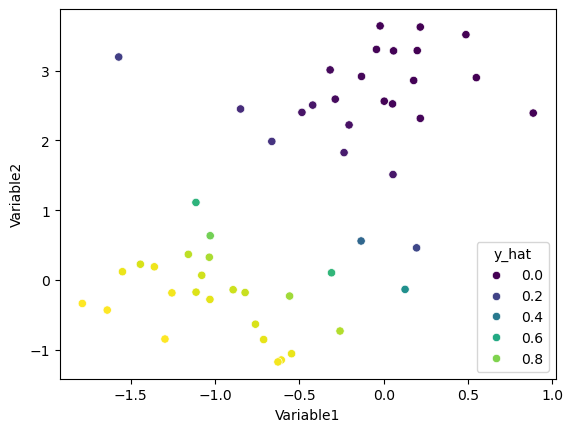

In [8]:
df["y_hat"] = idata.posterior_predictive.mean(dim="draw")["y"].values.squeeze()
sns.scatterplot(data=df, x="Variable1", y="Variable2", hue="y_hat", palette="viridis")

## References

:::{bibliography}
:filter: docname in docnames
:::

## Authors

* Authored by Thomas Wiecki on Oct 11 2022 ([pymc-examples#429](https://github.com/pymc-devs/pymc-examples/pull/429))
* Re-execute notebook by Reshama Shaikh on Feb 5, 2023
* Bug fix by Chris Fonnesbeck on Jul 17, 2024
* Changed to model to logistic regression by Chris Fonnesbeck on Sep 17, 2024

## Watermark

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Tue Sep 17 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

xarray: 2024.7.0

pandas           : 2.2.2
pymc_experimental: 0.1.2
seaborn          : 0.13.2
numpy            : 1.26.4
matplotlib       : 3.9.2
arviz            : 0.19.0
pymc             : 5.16.2

Watermark: 2.4.3



:::{include} ../page_footer.md
:::